## Import libraries 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

## Reading Data

In [2]:
os.chdir("F:\AI&DS\ML\CustomerSegmentProject\\")

retail = pd.read_excel("Online Retail.xlsx")

retail_df = retail.copy()

retail_df.info()

retail_df.describe().round(2)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 541909 entries, 0 to 541908
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   InvoiceNo    541909 non-null  object        
 1   StockCode    541909 non-null  object        
 2   Description  540455 non-null  object        
 3   Quantity     541909 non-null  int64         
 4   InvoiceDate  541909 non-null  datetime64[ns]
 5   UnitPrice    541909 non-null  float64       
 6   CustomerID   406829 non-null  float64       
 7   Country      541909 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(1), object(4)
memory usage: 33.1+ MB


,Quantity,UnitPrice,CustomerID
count,541909.00,541909.00,406829.00
mean,9.55,4.61,15287.69
std,218.08,96.76,1713.60
min,-80995.00,-11062.06,12346.00
25%,1.00,1.25,13953.00
50%,3.00,2.08,15152.00
75%,10.00,4.13,16791.00
max,80995.00,38970.00,18287.00


## Data Cleaning

In [3]:
retail_df.shape

retail_df.isna().sum()

retail_df.dropna(inplace=True)

retail_df.shape

retail_df["InvoiceNo"].str.contains('C').count()

retail_df = retail_df[~retail_df["InvoiceNo"].str.contains('C', na=False)]

retail_df.shape

retail_df.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


## Adding 'Total Price' column

In [4]:
retail_df['TotalPrice'] = retail_df['Quantity'] * retail_df['UnitPrice']

retail_df.shape

(397924, 9)

## RFM Analysis

In [5]:
import datetime as dt

retail_df['InvoiceDate'].max()

today_date = dt.datetime(2011, 12, 11)

rfm = retail_df.groupby("CustomerID").agg({'InvoiceDate': lambda date: (today_date-date.max()).days,
                                           'InvoiceNo': lambda num: num.nunique(),
                                           'TotalPrice': lambda TotalPrice: TotalPrice.sum()})

rfm.columns = ["Recency","Frequency","Monetary"]

rfm = rfm[rfm["Monetary"] > 0]

rfm["Recency_score"] = pd.qcut(rfm["Recency"],5,labels=[5,4,3,2,1])

rfm["Frequency_score"] = pd.qcut(rfm["Frequency"].rank(method='first'),5,labels=[1,2,3,4,5])

rfm["Monetary_score"] = pd.qcut(rfm["Monetary"],5,labels=[1,2,3,4,5])

rfm["RFM_score"] = (rfm["Recency_score"].astype(str) + rfm["Frequency_score"].astype(str))

seg_map = {
    
    r'[1-2][1-2]' : 'hibernating',
    r'[1-2][3-4]' : 'at_risk',
    r'[1-2]5' : 'cant_loose',
    r'3[1-2]' : 'about_to_sleep',
    r'33' : 'need_attention',
    r'[3-4][4-5]' : 'loyal_customers',
    r'41' : 'promising',
    r'51' : 'new_customers',
    r'[4-5][2-3]' : 'pot_loyal',
    r'5[4-5]' : 'champions'
    }

rfm['segment'] = rfm['RFM_score'].replace(seg_map, regex=True)

rfm.head()

,Recency,Frequency,Monetary,Recency_score,Frequency_score,Monetary_score,RFM_score,segment
CustomerID,,,,,,,,
12346.0,326,1,77183.60,1,1,5,11,hibernating
12347.0,3,7,4310.00,5,5,5,55,champions
12348.0,76,4,1797.24,2,4,4,24,at_risk
12349.0,19,1,1757.55,4,1,4,41,promising
12350.0,311,1,334.40,1,1,2,11,hibernating


## 2D visualization of RFM Analysis

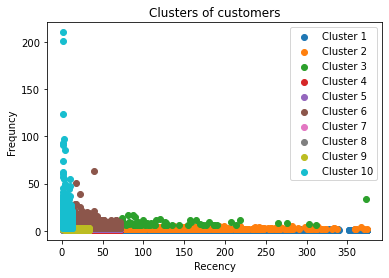

In [6]:
seg_list = list(seg_map.values())
for i in range(1,11):
    plt.scatter(rfm['Recency'][rfm['segment']==seg_list[i-1]] , rfm['Frequency'][rfm['segment']==seg_list[i-1]], label = 'Cluster '+str(i))
plt.title('Clusters of customers')
plt.xlabel('Recency')
plt.ylabel('Frequncy')
plt.legend()
plt.show()

## K-means clustring

In [7]:
from sklearn.cluster import KMeans

X = rfm.iloc[:,[0,1]].values

### Elbow Method

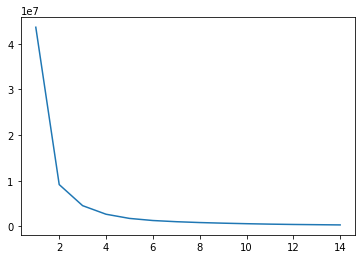

In [8]:
# In this method we choose the optimum number of clusters depending on the wcss (within cluster sum of squares) metric 
# for each number of cluster, the optimum point is where the curve changes smoothly
wcss = []
for i in range(1,15):
    kmeans = KMeans(n_clusters=i, init="k-means++", random_state=42)
    kmeans.fit(X) ## it just fits the model and doesn't return the labels, you can access them using kmeans.labels_
    wcss.append(kmeans.inertia_)
    
plt.plot(range(1,15), wcss)
# the optimum number of clusters can be 2 or 3

### Fitting the model and test 
#### no_clusters = 10

In [14]:
# we train the model with the same number of clusters of RFM to compare between KMeans and RFM
kmeans = KMeans(n_clusters=10, init="k-means++", random_state=42)
y_kmeans = kmeans.fit_predict(X)

# Model Testing 
y_test = kmeans.predict([[100,10]])
print("the cluster is ",y_test+1) # we shift the predicted cluster by 1, because ".predict" method is 0 based 

the cluster is  [3]


####  2D visualization of 10 clusters

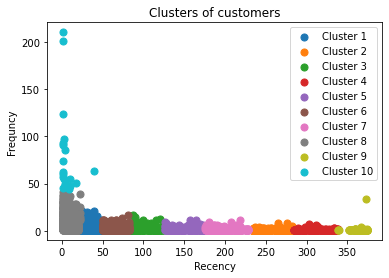

In [15]:
for i in range(1,11):
    plt.scatter(X[y_kmeans == i-1, 0], X[y_kmeans == i-1, 1], s = 50, label = 'Cluster '+str(i))
plt.title('Clusters of customers')
plt.xlabel('Recency')
plt.ylabel('Frequncy')
plt.legend()
plt.show()

#### no_clusters = 3 ( the optimum according to Elbow method )

In [16]:
kmeans = KMeans(n_clusters=3, init="k-means++", random_state=42)
y_kmeans = kmeans.fit_predict(X)


# Model Testing 
y_test = kmeans.predict([[100,10]])
print("the cluster is ",y_test+1) # we shift the predicted cluster by 1, because ".predict" method is 0 based 

the cluster is  [1]


####  2D visualization of 3 clusters

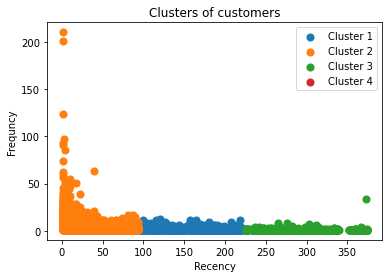

In [17]:
for i in range(1,5):
    plt.scatter(X[y_kmeans == i-1, 0], X[y_kmeans == i-1, 1], s = 50, label = 'Cluster '+str(i))
plt.title('Clusters of customers')
plt.xlabel('Recency')
plt.ylabel('Frequncy')
plt.legend()
plt.show()

## Hierarchical Clustering

In [18]:
import scipy.cluster.hierarchy as sch

X = rfm.iloc[:,[0,1]].values

### Dendrogram visualiztion

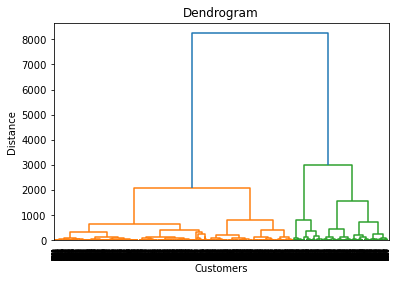

In [19]:
dendrogram = sch.dendrogram(sch.linkage(X, method='ward'))

plt.title("Dendrogram")

plt.xlabel("Customers")

plt.ylabel("Distance")

plt.show()

# it can be shown that the best number of clusters is 2 clusters

### Fitting the model
#### no_clusters = 10

In [30]:
from sklearn.cluster import AgglomerativeClustering

hc = AgglomerativeClustering(n_clusters=10, affinity='euclidean', linkage= 'ward')

y_hc = hc.fit_predict(X)

####  2D visualization of 10 clusters

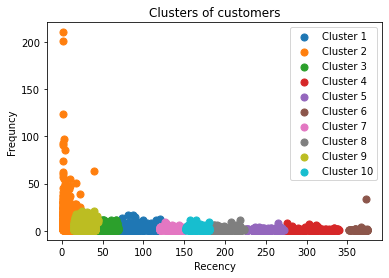

In [31]:
for i in range(1,11):
    plt.scatter(X[y_hc == i-1, 0], X[y_hc == i-1, 1], s = 50, label = 'Cluster '+str(i))
plt.title('Clusters of customers')
plt.xlabel('Recency')
plt.ylabel('Frequncy')
plt.legend()
plt.show()

#### no_clusters = 2

In [22]:
from sklearn.cluster import AgglomerativeClustering

hc = AgglomerativeClustering(n_clusters=2, affinity='euclidean', linkage= 'ward')

y_hc = hc.fit_predict(X)

#### 2D visualization of 2 clusters

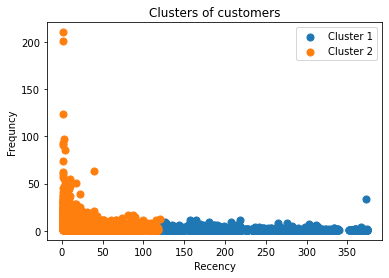

In [23]:
for i in range(1,3):
    plt.scatter(X[y_hc == i-1, 0], X[y_hc == i-1, 1], s = 50, label = 'Cluster '+str(i))
plt.title('Clusters of customers')
plt.xlabel('Recency')
plt.ylabel('Frequncy')
plt.legend()
plt.show()

### HC Model Testing

In [32]:
# In hierarchical clustering, unlike k-means, there is no direct equivalent of the "centroid" concept, 
# which makes predicting new data points after the model is trained a bit more complex.
# To overcome this issue, we will trian KNN model on the new data after we obtained the labels from HC Model. 

train_labels = hc.labels_

from sklearn.neighbors import KNeighborsClassifier

knn = KNeighborsClassifier(n_neighbors=5)

knn.fit(X, train_labels)

y_test = knn.predict([[100,10]])
print("the cluster is ",y_test+1) # it is like the graph

the cluster is  [1]
